In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']

from matplotlib.pylab import rcParams
#rcParams['figure.figsize']=20,6

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
#制作ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [58]:
def plot_acf_pacf(ts,title,lags=31):
    plt.figure(figsize=(20,6))
    plt.plot(ts)
    plt.xlabel('time')
    plt.title(title)
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    plot_acf(ts,ax=ax[0],lags=lags)
    plot_pacf(ts,ax=ax[1],lags=lags)
    plt.show()

In [37]:
#ADF单位根检验函数
def ADF(ts,regression='c'):
    print('Results of Augmented Dickey-Fuller Test:')
    test = adfuller(ts,autolag='AIC')
    result = pd.Series(test[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for k,v in test[4].items():
        result['critical values {}'.format(k)]=v
    print(result)

In [11]:
# 白噪声检验：Ljung-Box test
def etest(series,lags=31):
    rdtest = acorr_ljungbox(series,lags)
        # 对上述函数求得的值进行语义描述
    rddata = np.c_[range(1,lags+1),rdtest[1:][0]]
    rdoutput = pd.DataFrame(rddata,columns=['lags','p-value'])
    return rdoutput.set_index('lags')

In [13]:
#加载数据
call = pd.read_csv('C:/Users/acerpc/Desktop/data_folder/call.csv')
train_call = call.loc[0:183,['starting_date','dotcom_calls']]
test_call = call.loc[184:262,['starting_date','dotcom_calls']]
call.head()

,week_num,starting_date,ending_date,dotcom_calls,dtv800_calls
0,1,1/2/2011,1/8/2011,29102.0,52000.0
1,2,1/9/2011,1/15/2011,26266.0,43152.0
2,3,1/16/2011,1/22/2011,25836.0,43312.0
3,4,1/23/2011,1/29/2011,24860.0,44175.0
4,5,1/30/2011,2/5/2011,25803.0,51108.0


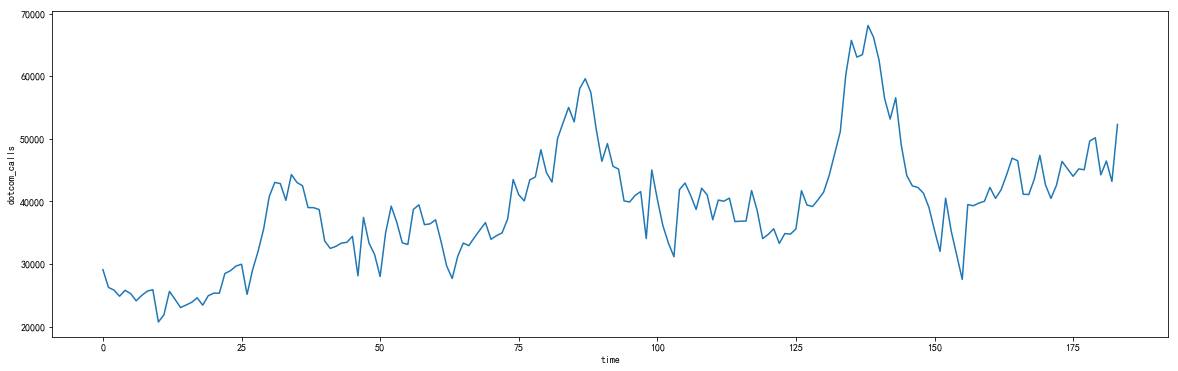

In [29]:
#第一步：时序图,平稳性
plt.figure(figsize=(20,6))
plt.plot(train_call.dotcom_calls)
plt.xlabel('time')
plt.ylabel('dotcom_calls')
plt.show()

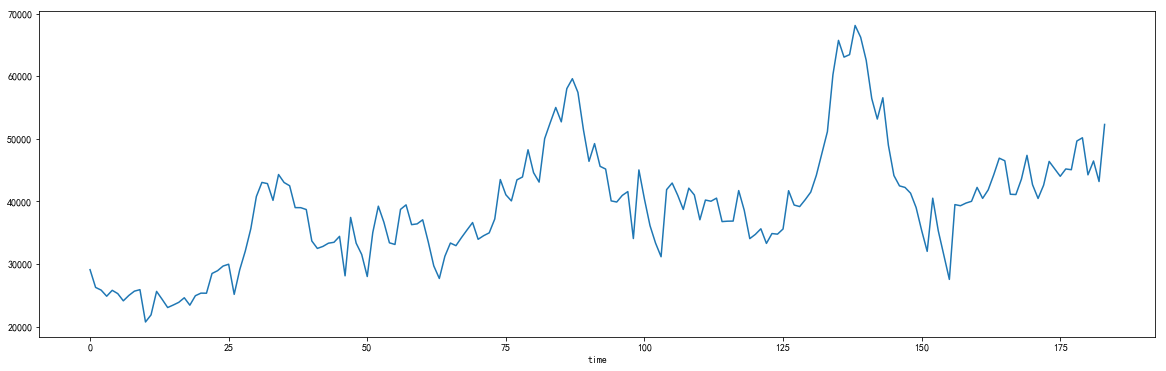

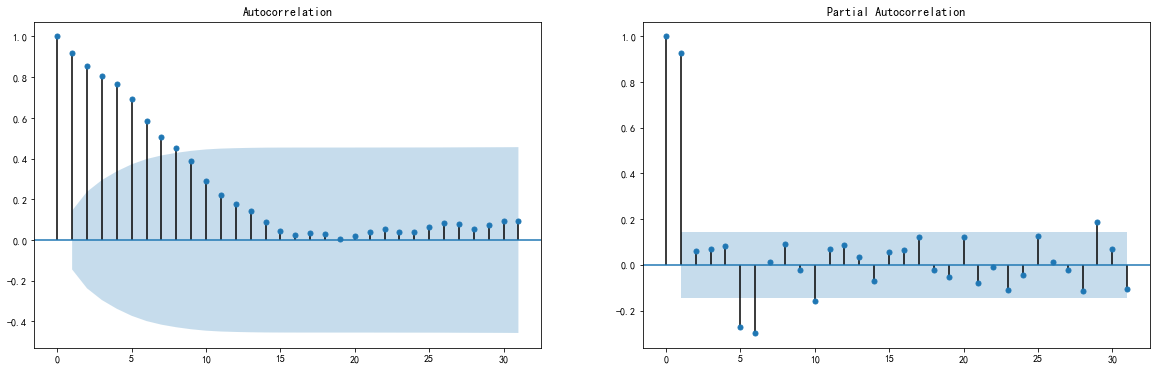

In [30]:
plot_acf_pacf(train_call.dotcom_calls,'dotcom_calls')

In [38]:
ADF(train_call.dotcom_calls)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.390648
p-value                          0.011282
#Lags Used                       5.000000
Number of Observations Used    178.000000
critical values 1%              -3.467632
critical values 5%              -2.877918
critical values 10%             -2.575501
dtype: float64


In [40]:
etest(train_call.dotcom_calls,7)#不是白噪声

,p-value
lags,
1.0,2.453199e-36
2.0,4.851739e-65
3.0,2.089182e-90
4.0,1.831041e-113
5.0,4.491206e-132
6.0,2.583659e-145
7.0,5.460204e-155


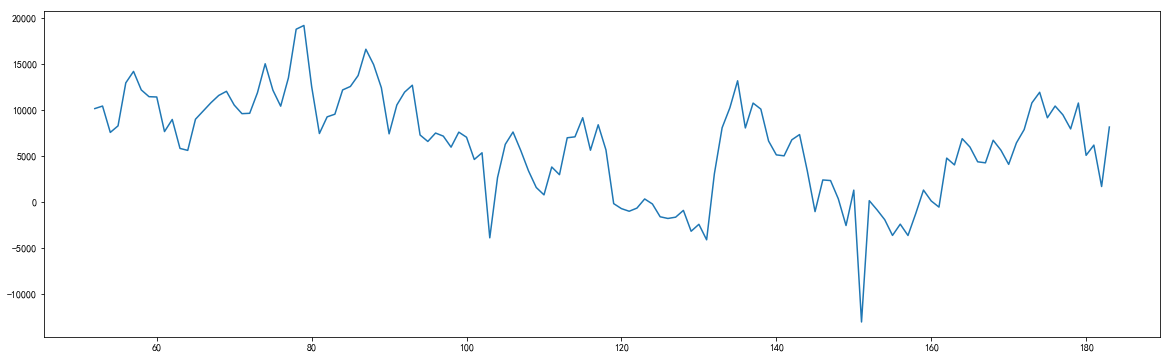

In [51]:
#第二步：若非平稳，进行差分
#一阶52步的差分,去除趋势, 因为该数据是周水平上的，从时序图上能看到具有年度周期
call_1 = train_call.dotcom_calls.diff(52)
call_1 = call_1[52:]
plt.figure(figsize=(20,6))
plt.plot(call_1)

D:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


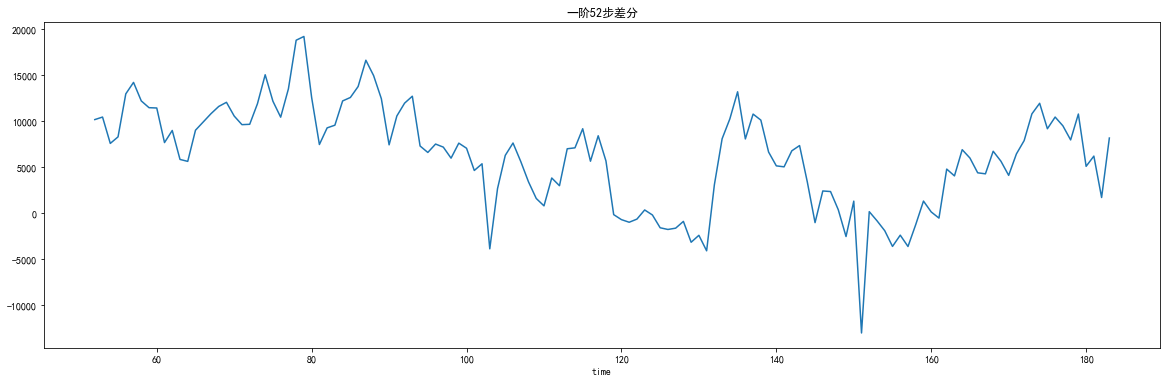

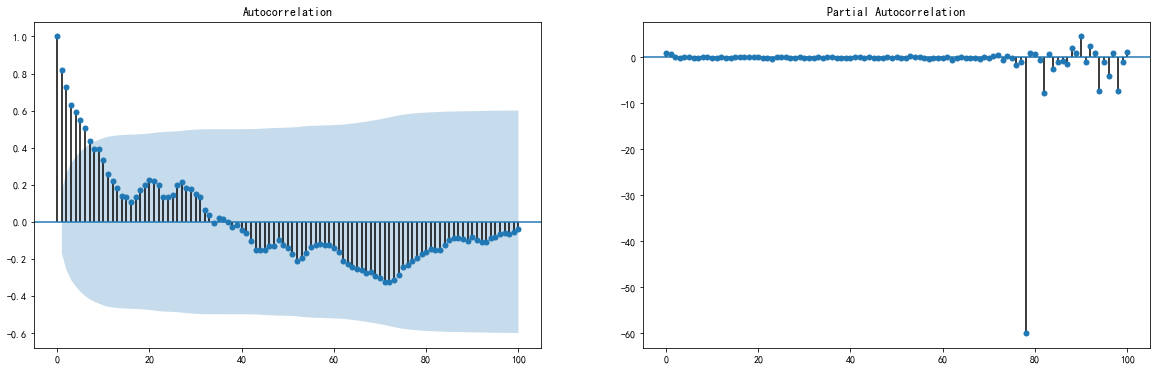

In [60]:
plot_acf_pacf(call_1,'一阶52步差分',100)

In [55]:
ADF(call_1)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.909385
p-value                          0.044268
#Lags Used                       1.000000
Number of Observations Used    130.000000
critical values 1%              -3.481682
critical values 5%              -2.884042
critical values 10%             -2.578770
dtype: float64


D:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


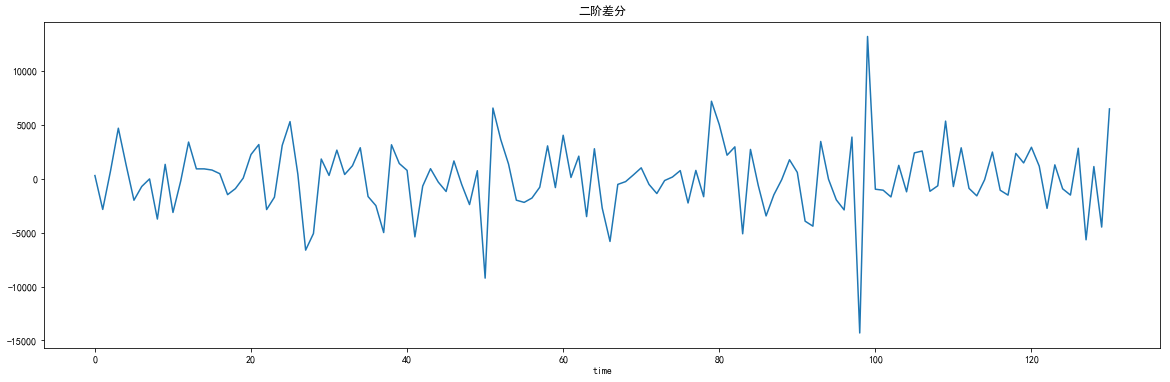

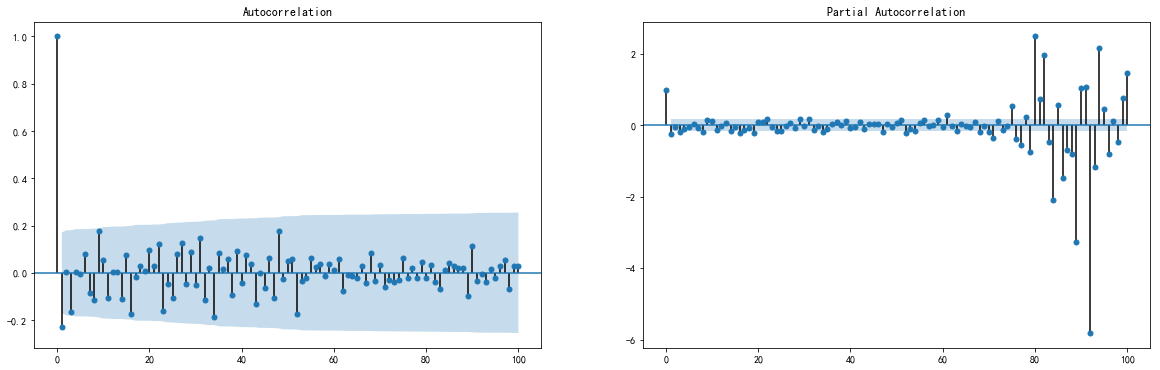

In [61]:
call_2 = np.diff(call_1,n=1)
plot_acf_pacf(call_2,'二阶差分',100)

In [62]:
ADF(call_2)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.600895e+00
p-value                        6.873866e-14
#Lags Used                     2.000000e+00
Number of Observations Used    1.280000e+02
critical values 1%            -3.482501e+00
critical values 5%            -2.884398e+00
critical values 10%           -2.578960e+00
dtype: float64


In [73]:
#第三步：模型识别
best_aic = np.inf 
best_order = None
best_model = None

pq_rng = range(3)
d_rng = range(1)

for p in pq_rng:
    for q in pq_rng:
        for d in d_rng:
            try:
                tem_model = smt.ARIMA(call_2,order=(p,d,q)).fit()
                tem_aic = tem_model.aic
                print('aic:{}|order:{}'.format(tem_aic,(p,d,q)))
                if tem_aic < best_aic:
                    best_aic = tem_aic
                    best_order = (p,d,q)
                    best_model = tem_model
            except:
                continue
print('-'*20)
print('best_aic:{},best_order:{}'.format(best_aic,best_order))

D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

aic:2493.8402260788166|order:(0, 0, 0)
aic:2487.1557068846696|order:(0, 0, 1)
aic:2488.019067519977|order:(0, 0, 2)
aic:2488.444561322168|order:(1, 0, 0)
aic:2485.499702983003|order:(1, 0, 1)
aic:2490.110809195987|order:(2, 0, 0)
aic:2484.6477926998255|order:(2, 0, 1)
aic:2485.9402179111016|order:(2, 0, 2)
--------------------
best_aic:2484.6477926998255,best_order:(2, 0, 1)


In [76]:
#第四步： 模型拟合，参数估计
#fit(1,0,1)
call_arima = smt.ARIMA(call_2,order=(1,0,1)).fit()
print(call_arima.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  131
Model:                     ARMA(1, 1)   Log Likelihood               -1238.750
Method:                       css-mle   S.D. of innovations           3060.598
Date:                Mon, 31 Dec 2018   AIC                           2485.500
Time:                        18:31:41   BIC                           2497.000
Sample:                             0   HQIC                          2490.173
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -59.8976     29.833     -2.008      0.047    -118.370      -1.426
ar.L1.y        0.7830      0.057     13.742      0.000       0.671       0.895
ma.L1.y       -1.0000      0.035    -28.337      0.0

D:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


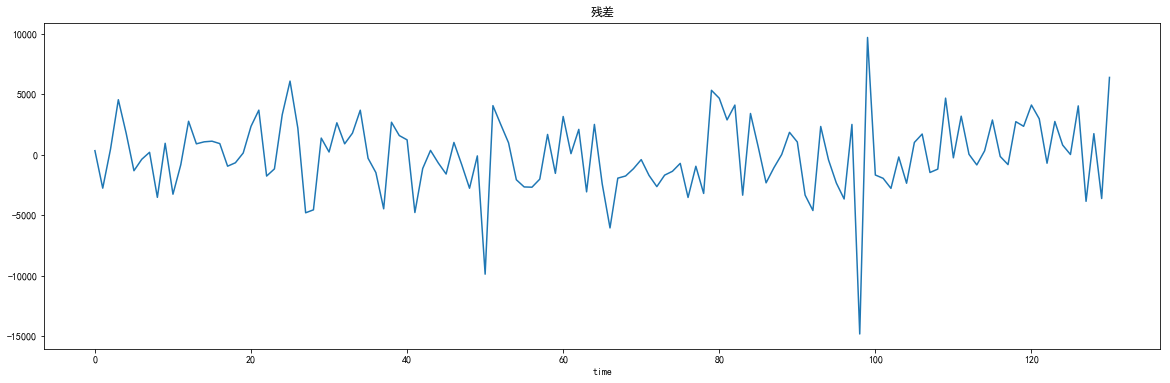

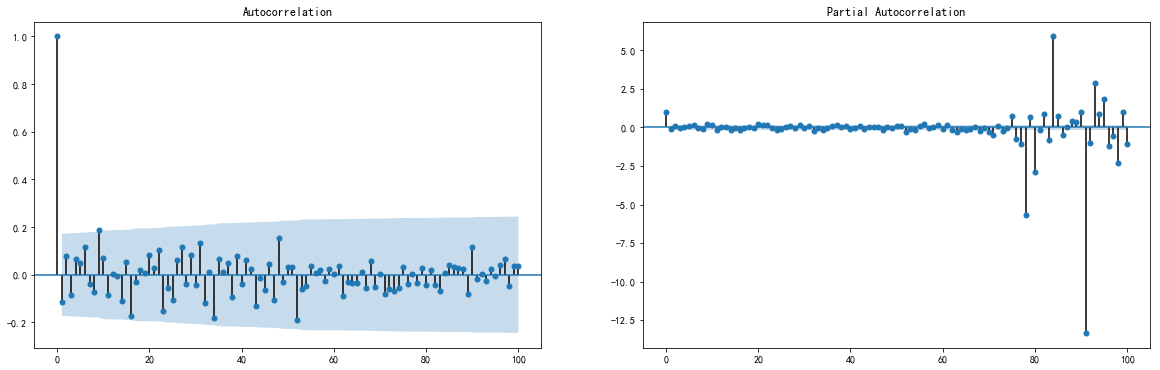

In [78]:
#第五步： 模型检验
plot_acf_pacf(call_arima.resid,'残差',100)

In [80]:
etest(call_arima.resid,7)

,p-value
lags,
1.0,0.188126
2.0,0.275212
3.0,0.315606
4.0,0.389140
5.0,0.484988
6.0,0.386834
7.0,0.479702


In [90]:
#第六步:模型预测
train_call_final = train_call.set_index('starting_date')
sarima = smt.SARIMAX(train_call_final,order=(1,1,1),seasonal_order=(0,1,0,52)).fit()
print(sarima.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                       dotcom_calls   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 52)   Log Likelihood               -1240.862
Date:                            Mon, 31 Dec 2018   AIC                           2487.723
Time:                                    19:14:38   BIC                           2496.349
Sample:                                01-02-2011   HQIC                          2491.228
                                     - 07-06-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5221      0.247      2.109      0.035       0.037       1.007
ma.L1         -0.7172      0.209   

In [92]:
test_call_final = test_call.set_index('starting_date')
test_call_final['pred'] = sarima.forecast(len(test_call))
test_call_final.head()

,dotcom_calls,pred
starting_date,,
7/13/2014,54044.0,55375.327964
7/20/2014,55749.0,58639.056129
7/27/2014,58933.0,67628.494119
8/3/2014,59781.0,73040.641382
8/10/2014,60648.0,70334.872407


In [96]:
from sklearn.metrics import mean_squared_error
print('RMSE:',np.sqrt(mean_squared_error(test_call_final.dotcom_calls,test_call_final.pred)))

RMSE: 6804.842873870098


In [102]:
#HoltWinters 指数平滑法模型拟合
holtwinter = ExponentialSmoothing(np.asarray(train_call_final.dotcom_calls),trend='add',seasonal='add',seasonal_periods=52).fit()
test_call_final['holtwinter'] = holtwinter.forecast(len(test_call))
print('holtwinter RMSE:',np.sqrt(mean_squared_error(test_call_final.dotcom_calls,test_call_final.holtwinter)))

holtwinter RMSE: 5365.141898133237


In [105]:
#简单平均法
test_call_final['simpleaverage'] = np.mean(train_call_final.dotcom_calls)
print('simpleaverage RMSE:',np.sqrt(mean_squared_error(test_call_final.dotcom_calls,test_call_final.simpleaverage)))

simpleaverage RMSE: 18234.86471469206


In [106]:
#naive
snaive = np.array(train_call.dotcom_calls[132:184])
snaive_26 = np.array(snaive[0:26])
pre_snaive = np.hstack((snaive,snaive_26))
test_call_final['Snaive'] = pre_snaive
np.sqrt(mean_squared_error(test_call_final.dotcom_calls,test_call_final.Snaive))

10665.543494710624

In [107]:
#简单指数平滑法
simplexp = SimpleExpSmoothing(train_call_final.dotcom_calls).fit()
test_call_final['simplexp'] = simplexp.forecast(len(test_call_final))
np.sqrt(mean_squared_error(test_call_final.dotcom_calls,test_call_final.simplexp))

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


9254.894593948222

In [108]:
test_call_final.head()

,dotcom_calls,pred,holtwinter,simpleaverage,Snaive,simplexp
starting_date,,,,,,
7/13/2014,54044.0,55375.327964,51311.524007,39143.777174,47663.0,51499.930219
7/20/2014,55749.0,58639.056129,52810.514638,39143.777174,51150.0,51499.930219
7/27/2014,58933.0,67628.494119,60168.289992,39143.777174,60256.0,51499.930219
8/3/2014,59781.0,73040.641382,63356.298183,39143.777174,65729.0,51499.930219
8/10/2014,60648.0,70334.872407,62249.469079,39143.777174,63055.0,51499.930219


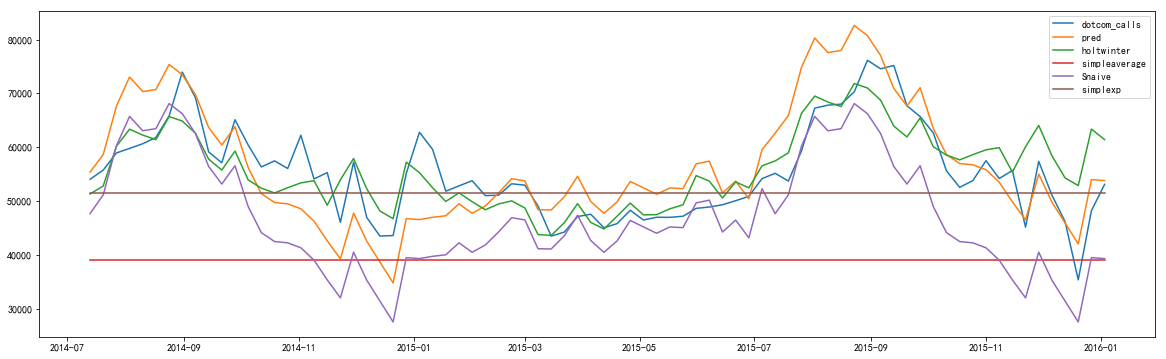

In [112]:
test_call_final.index = pd.to_datetime(test_call_final.index)
plt.figure(figsize = (20,6))
for col in test_call_final.columns:
    plt.plot(test_call_final[col],label=col)
plt.legend()
plt.show()

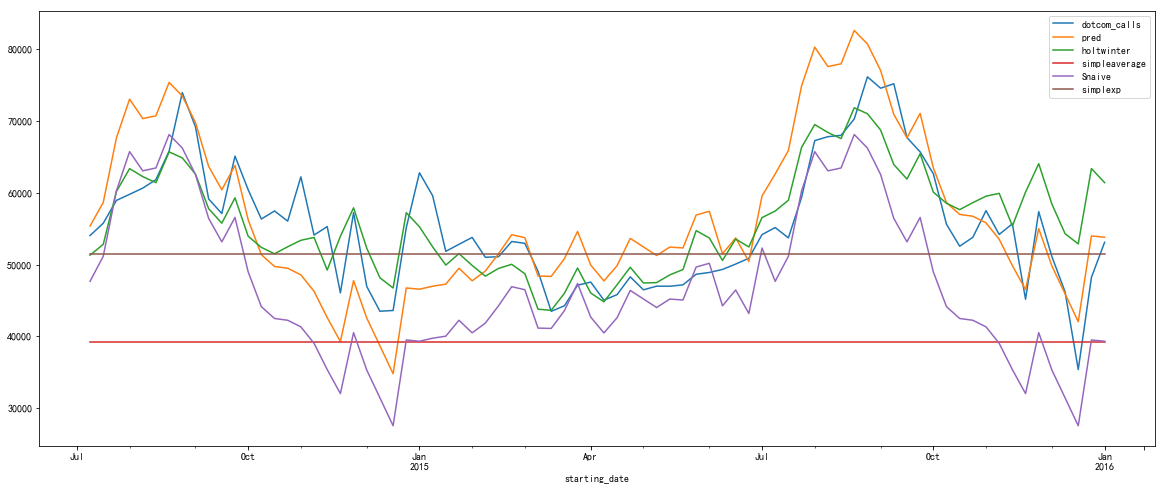

In [114]:
test_call_final.plot(figsize=(20,8))